In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from bin.utils import iterate_fasta, barplot, plot_logo
from Bio import SeqIO
import logomaker
from abnumber import Chain, Position
from matplotlib import ticker

%config InlineBackend.figure_format = 'retina'

In [2]:
SCHEME = 'kabat'
SOURCE_DATA = '../../../oas-dataset/data'
OAS_HIT_DIR = '../../data/tasks/therapeutic_rediscovery/oas_hits'

In [3]:
mabs = pd.read_csv('../../data/sabdab/TheraSAbDab_clean.tsv', sep='\t', index_col=0)
mabs.head(3)

,Format,Suffix,CH1 Isotype,VD LC,Highest_Clin_Trial (Jan '20),Est. Status,Heavy Sequence,Light Sequence,Heavy Sequence (if bispec),Light Sequence (if bispec),...,95-98% SI Structure,Year Proposed,Year Recommended,Target,Companies,Conditions Approved,Conditions Active,Conditions Discontinued,Development Tech,Notes
Therapeutic,,,,,,,,,,,,,,,,,,,,,
Abagovomab,Whole mAb,-omab,G1,Kappa,Phase-III,Discontinued,QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLD...,DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQL...,NaN,NaN,...,None,2006,2007.0,CA125,Menarini,NaN,NaN,Ovarian cancer;Pancreatic cancer,NaN,NaN
Abelacimab,Whole mAb,-imab,G1,Lambda,Unknown,Unknown,QVQLLESGGGLVQPGGSLRLSCAASGFTFSTAAMSWVRQAPGKGLE...,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNDVSWYQQLPGTAPK...,NaN,NaN,...,6r8x:CB,2018,2019.0,F11,Novartis,NaN,Thromboembolism,NaN,NaN,NaN
Abituzumab,Whole mAb,-zumab,G2,Kappa,Phase-II,Active,QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...,NaN,NaN,...,None,2013,2014.0,ITGAV,Merck,NaN,Systemic scleroderma,Colorectal cancer;Ovarian cancer;Prostate canc...,NaN,"4o02 claims to be abituzumab (17E6), but is not"


In [4]:
all_units = pd.read_csv(os.path.join(SOURCE_DATA, 'all/meta/units.tsv'), sep='\t').set_index('UnitPath')
all_units['species_simple'] = all_units['Species'].str.replace('_.*','').str.lower()

# Contains leaked mouse sequences
all_units = all_units[all_units['StudyPath'] != 'Corcoran_2016']

non_human_units = all_units[~all_units['Species'].isin(['human', 'HIS-mouse'])]

non_human_heavy_units = non_human_units[non_human_units['Chain'] == 'Heavy']
non_human_light_units = non_human_units[non_human_units['Chain'] == 'Light']
print(f'Loaded {len(non_human_heavy_units):,} non-human heavy units and {len(non_human_light_units):,} non-human light units')

human_units = all_units[all_units['Species'].isin(['human'])]

human_heavy_units = human_units[human_units['Chain'] == 'Heavy']
human_light_units = human_units[human_units['Chain'] == 'Light']
print(f'Loaded {len(human_heavy_units):,} human heavy units and {len(human_light_units):,} human light units')

Loaded 411 non-human heavy units and 45 non-human light units
Loaded 6,034 human heavy units and 273 human light units


In [5]:
all_units['species_simple'].str.replace('_.*','').value_counts()

human        6307
mouse         384
rat            56
his-mouse      12
rabbit          7
camel           6
rhesus          3
Name: species_simple, dtype: int64

In [6]:
def merge_hits(units, query_chains, hit_dir):
    best_hits = {}
    missing = 0

    full_len = query_chains.apply(len)

    for unit_path, unit in units.iterrows():
        path = os.path.join(hit_dir, unit['StudyPath'], unit_path+'.csv')
        if not os.path.exists(path):
            missing += 1
            continue
        hits = pd.read_csv(path).set_index('Id', verify_integrity=True)
        if 'num_matches' not in hits.columns:
            continue
        position_columns = [col_name for col_name in hits.columns if col_name[0].isnumeric()]
        for name, hit in hits.iterrows():
            if name not in query_chains.index:
                continue
            num_matches = hit['num_matches']
            if name not in best_hits or num_matches >= best_hits[name]['num_matches']:
                identity = num_matches / full_len.loc[name]
                seq = ''.join(hit[position_columns]).replace('-','')
                best_hits[name] = {
                    'num_matches': num_matches,
                    'identity': identity,
                    'species': hit['species'],
                    'hit_name': hit['hit_name'],
                    'hit_seq': seq,
                    'hit_unit': unit_path,
                    'hit_study': unit['StudyPath']
                }
    best_hits = pd.DataFrame.from_dict(best_hits, orient='index').sort_index()

    if missing:
        print(f'\nWarning: {missing}/{len(units)} units were missing!')
    return best_hits

# Heavy chain

In [7]:
query_heavy_chains = Chain.from_anarci_csv(f'../../data/tasks/therapeutic_rediscovery/thera/humanized_{SCHEME}_H.csv', scheme=SCHEME, as_series=True)

query_heavy_chains.head()

Abituzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Afutuzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, V), ...
Alacizumab      ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
Alemtuzumab     ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Anrukinzumab    ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
dtype: object

In [8]:
heavy_hits = merge_hits(non_human_heavy_units, query_heavy_chains, os.path.join(OAS_HIT_DIR, 'heavy'))

print('Best matches:')
heavy_hits.sort_values(['identity'], ascending=False).head()


Best matches:


,num_matches,identity,species,hit_name,hit_seq,hit_unit,hit_study
Itolizumab,108,0.907563,alpaca,153446,EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYAMSWVRQTPEKRLE...,Greiff_2017_pet_mouse_2_naive_B_cell_IGHM_pet_...,Greiff_2017
Crenezumab,101,0.901786,alpaca,Query_168910,EVQLVESGGGLVQPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,Collins_2015_IGHM_Mouse_sample_2_iglblastn_igb...,Collins_2015
Elotuzumab,107,0.899160,alpaca,Query_1374664,EVQLVESGGGLVQPGGSLKLSCAASGFDFSRYWMSWVRQAPGKGLE...,Greiff_2017_C57BL_mouse_4_PC_IGHM_IGHG_IGHM_C5...,Greiff_2017
Camrelizumab,104,0.896552,alpaca,1141762,EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYTMSWVRQTPEKRLE...,Greiff_2017_OVA_mouse_1_pre-B_cell_bone_marrow...,Greiff_2017
Enavatuzumab,105,0.882353,mouse,Query_80402,EVQLVESGGGLVQPGGSMKLSCVASGFTFSSYWMSWVRQSPEKGLE...,Greiff_2015_antibody_secreting_IGHM_antibody_s...,Greiff_2015


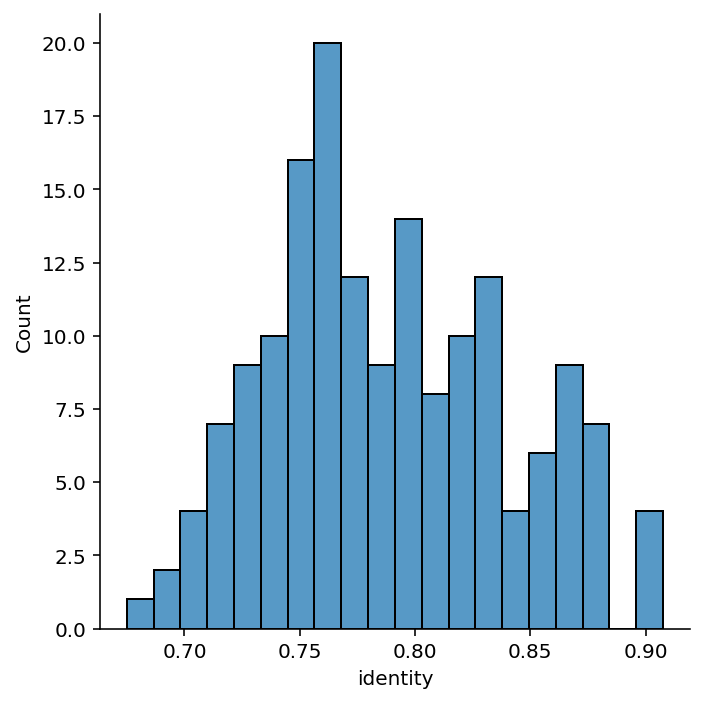

In [9]:
sns.displot(heavy_hits['identity'], bins=20);

In [10]:
heavy_human_hits = merge_hits(human_heavy_units, query_heavy_chains, os.path.join(OAS_HIT_DIR, 'heavy'))

heavy_human_hits.sort_values(['identity'], ascending=False).head(5)

,num_matches,identity,species,hit_name,hit_seq,hit_unit,hit_study
Tibulizumab,122,0.991870,rhesus,SRR5811763.3170326 3170326,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...,Waltari_2018_Heavy_Healthy_PBMCs_IGHM_Heavy_He...,Waltari_2018
Vanucizumab,124,0.961240,human,ERR2567233.413855 M00619:250:000000000-ARC2R:1...,QVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,Gidoni_2019_Heavy_Healthy-celiac-disease_IGHM_...,Gidoni_2019
Zenocutuzumab,117,0.943548,human,Query_1328705,QVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,Gupta_2017_Heavy_IB_volunteer_IGHM_IB_after_3d...,Gupta_2017
Telisotuzumab,110,0.932203,human,SRR5888724.198512 198512,QVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,Landais_2017_Heavy_Month-V42_IGHG_Heavy_Month-...,Landais_2017
Emactuzumab,108,0.931034,human,Query_782548,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...,Vergani_2017_B10_age-38_IGHM_B10_age-38_iglbla...,Vergani_2017


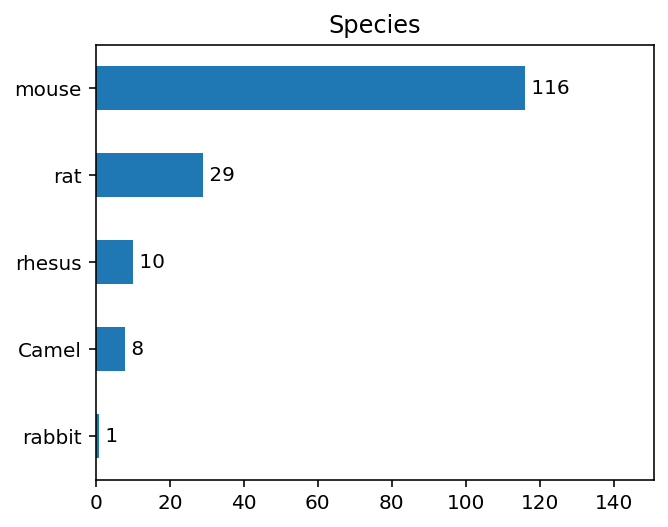

In [11]:
heavy_species = pd.Series(all_units.loc[heavy_hits['hit_unit']]['Species'].str.replace('_.*','').values, heavy_hits.index, name='Species')
barplot(heavy_species.value_counts(), figsize=(5, 4));

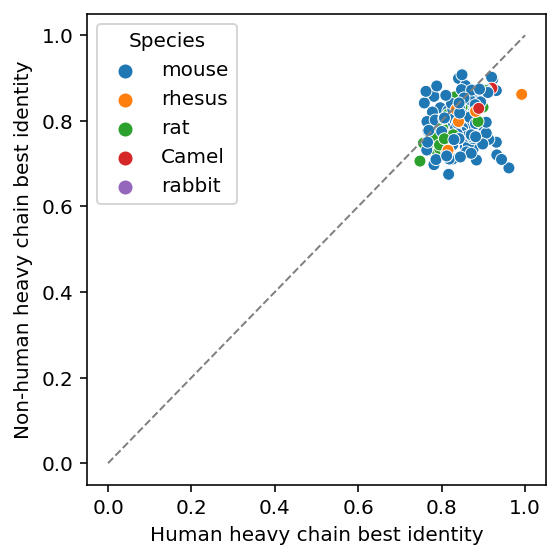

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x=heavy_human_hits['identity'], y=heavy_hits['identity'], hue=heavy_species, ax=ax)
ax.set_xlabel('Human heavy chain best identity')
ax.set_ylabel('Non-human heavy chain best identity')
ax.plot([0, 1], [0, 1], ls='--', lw=1, color='grey');

fig.tight_layout()

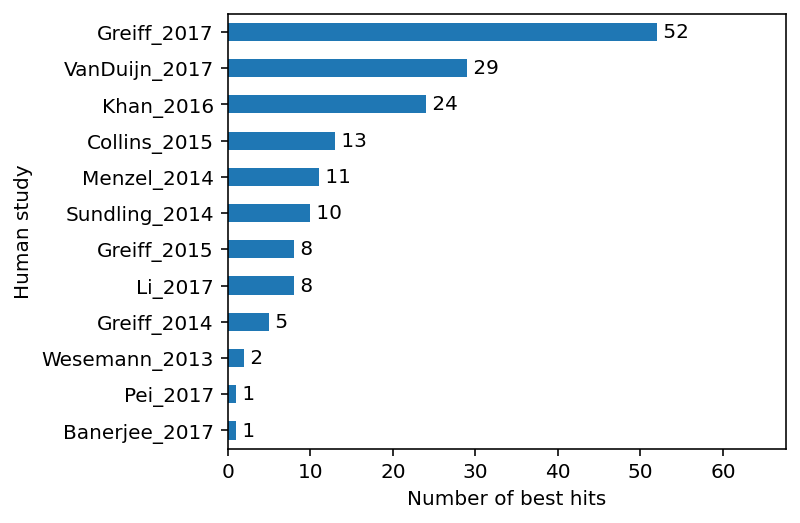

In [13]:
ax = barplot(heavy_hits['hit_study'].value_counts(), figsize=(5, 4));
ax.set_xlabel('Number of best hits')
ax.set_ylabel('Human study');
ax.set_title('');

In [14]:
hit_heavy_chains = pd.Series({name: Chain(hit['hit_seq'], scheme=SCHEME, name=name) for name, hit in heavy_hits.iterrows()})
hit_heavy_chains.head()

Abituzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Afutuzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Alacizumab      ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
Alemtuzumab     ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Anrukinzumab    ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
dtype: object

In [15]:
backgrafted_heavy_chains = pd.Series({name: query.graft_cdrs_onto(hit_heavy_chains.loc[name]) 
                                  for name, query in query_heavy_chains.items()})
backgrafted_heavy_chains.head()

Abituzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Afutuzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Alacizumab      ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
Alemtuzumab     ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Anrukinzumab    ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
dtype: object

In [16]:
heavy_hits.loc['Abituzumab'][:8]

num_matches                                                   98
identity                                                0.830508
species                                                    mouse
hit_name                                                  556777
hit_seq        QVQLQQSGAELAKPGASVKLSCKASGYTFTSYWMHWVKQRPGQGLE...
hit_unit       Greiff_2017_pet_mouse_3_naive_B_cell_IGHM_pet_...
hit_study                                            Greiff_2017
Name: Abituzumab, dtype: object

In [17]:
query_heavy_chains.loc['Abituzumab'].align(hit_heavy_chains.loc['Abituzumab'])

QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLEWIGYINPRSGYTEYNEIFRDKATMTTDTSTSTAYMELSSLRSEDTAVYYCASFLGRGAMDYWGQGTTVTVSS
||||||||.||||||||||+|||||||||+|+|||||+|.|||||||||||||.||||+||+.|+||||+|.|.|+|||||+||||.|||+||||||.||||||||||||||+|||||
QVQLQQSGAELAKPGASVKLSCKASGYTFTSYWMHWVKQRPGQGLEWIGYINPSSGYTKYNQKFKDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^°          

In [18]:
query_heavy_chains.loc['Abituzumab'].align(backgrafted_heavy_chains.loc['Abituzumab'])

QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLEWIGYINPRSGYTEYNEIFRDKATMTTDTSTSTAYMELSSLRSEDTAVYYCASFLGRGAMDYWGQGTTVTVSS
||||||||.||||||||||+|||||||||+|||||||+|.|||||||||||||||||||||||||||||+|.|.|+|||||+||||.|||+||||||.||||||||||||||+|||||
QVQLQQSGAELAKPGASVKLSCKASGYTFTSFWMHWVKQRPGQGLEWIGYINPRSGYTEYNEIFRDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^°          

In [19]:
hit_heavy_chains.loc['Abituzumab'].align(backgrafted_heavy_chains.loc['Abituzumab'])

QVQLQQSGAELAKPGASVKLSCKASGYTFTSYWMHWVKQRPGQGLEWIGYINPSSGYTKYNQKFKDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
|||||||||||||||||||||||||||||||+|||||||||||||||||||||.||||+||+.|+|||||||||||||||||||||||||||||||||||||||||||||||||||||
QVQLQQSGAELAKPGASVKLSCKASGYTFTSFWMHWVKQRPGQGLEWIGYINPRSGYTEYNEIFRDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^°          

# Light chain

In [20]:
query_light_chains = Chain.from_anarci_csv(f'../../data/tasks/therapeutic_rediscovery/thera/humanized_{SCHEME}_KL.csv', scheme=SCHEME, as_series=True)

query_light_chains.head()

Abituzumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Afutuzumab      ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
Alacizumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Alemtuzumab     ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Anrukinzumab    ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
dtype: object

In [21]:
all_units.groupby(['species_simple','Chain']).size()

species_simple  Chain
camel           Heavy       6
his-mouse       Heavy       9
                Light       3
human           Heavy    6034
                Light     273
mouse           Heavy     339
                Light      45
rabbit          Heavy       7
rat             Heavy      56
rhesus          Heavy       3
dtype: int64

In [22]:
light_hits = merge_hits(non_human_light_units, query_light_chains, os.path.join(OAS_HIT_DIR, 'light'))

print('Best hits:')
light_hits.sort_values(['identity'], ascending=False).head()

Best hits:


,num_matches,identity,species,hit_name,hit_seq,hit_unit,hit_study
Cantuzumab,106,0.946429,human,125306,DIVLTQSPPSVPVTPGESVSISCRSSKSLLHSNGNTYLYWFLQRPG...,Fisher_2017_Light_Naive_IAC1_Naive_Light_iglbl...,Fisher_2017
Flotetuzumab,105,0.929204,mouse,56885,DIVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSGNQKNYLTWYQQKP...,Fisher_2017_Light_Naive_IAC2_Naive_Light_iglbl...,Fisher_2017
Ibalizumab,104,0.928571,mouse,10998,DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYSSNQKNYLAWYQQKP...,Wesemann_2013_IgK_RAG+_B_lineage_cells_from_sm...,Wesemann_2013
Idarucizumab,102,0.910714,human,4901,DVVMTQTPLTLSVTIGQPASISCKSSQSLLYTNGKTYLNWLLQRPG...,Wesemann_2013_IgK_Lamina_propria_from_mice_col...,Wesemann_2013
Bapineuzumab,102,0.910714,rat,Query_4737990,DVVMTQSPLTLSVTIGQPASISCKSSQSLLDSDGKTYLNWLLQRPG...,Rettig_2018_Light_whole_spleen_Bulk_whole_sple...,Rettig_2018


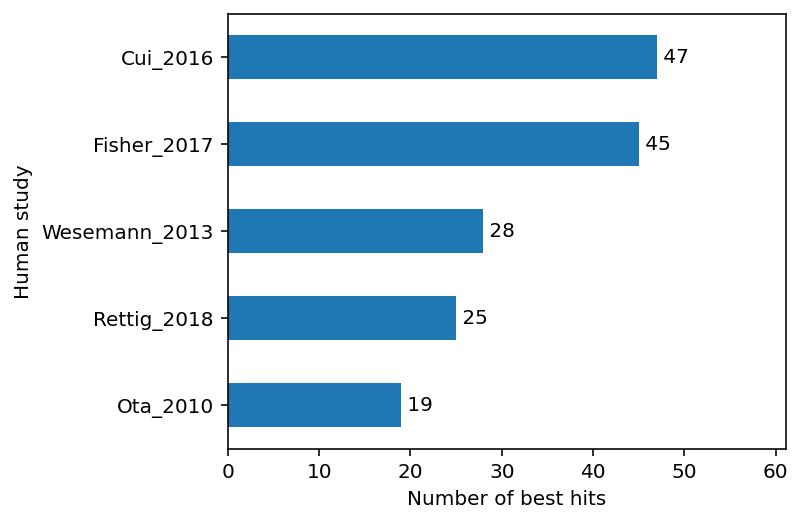

In [23]:
ax = barplot(light_hits['hit_study'].value_counts(), figsize=(5, 4));
ax.set_xlabel('Number of best hits')
ax.set_ylabel('Human study');
ax.set_title('');

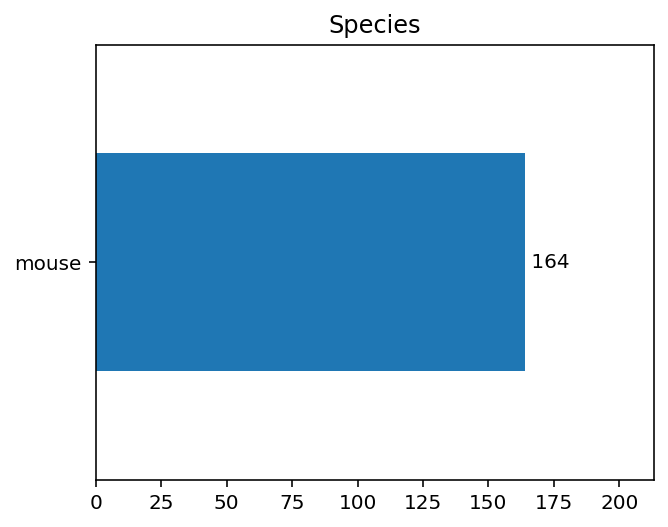

In [24]:
light_species = pd.Series(all_units.loc[light_hits['hit_unit']]['Species'].str.replace('_.*','').values, light_hits.index, name='Species')
barplot(light_species.value_counts(), figsize=(5, 4));

In [25]:
light_human_hits = merge_hits(human_light_units, query_light_chains, os.path.join(OAS_HIT_DIR, 'light'))

light_human_hits.sort_values(['identity'], ascending=False).head(5)

,num_matches,identity,species,hit_name,hit_seq,hit_unit,hit_study
Zenocutuzumab,107,1.000000,human,250659,DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKL...,Zhu_2012_Light_Donor_39_light_chain_iglblastn,Zhu_2012
Tibulizumab,106,0.990654,human,419611,EIVLTQSPATLSLSPGERATLSCRASQSVSRYLAWYQQKPGQAPRL...,Gupta_2017_Light_Fv_volunteer_FV_after_1w_SRX2...,Gupta_2017
Vanucizumab,106,0.981481,human,ERR2567196.305480 M00619:252:000000000-ARAV0:1...,SYGLTQPPSVSVAPGQTARITCGGNNIGSKSVHWYQQKPGQAPVLV...,Gidoni_2019_Light_Healthy-celiac-disease_Bulk_...,Gidoni_2019
Refanezumab,108,0.964286,human,257896,DIVMTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...,Gupta_2017_Light_Fv_volunteer_FV_after_2w_SRX2...,Gupta_2017
Lumretuzumab,108,0.955752,human,466357,DIVMTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLTWYQQKP...,Vander_Heiden_2017_Light_MK08_MK08_Naive_Bcell...,Vander_Heiden_2017


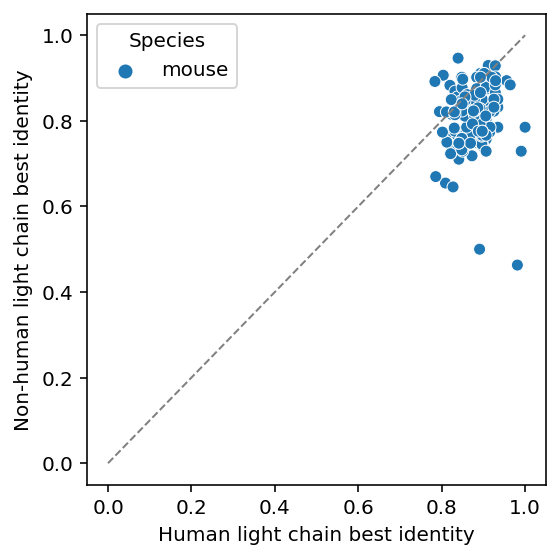

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x=light_human_hits['identity'], y=light_hits['identity'], hue=light_species, ax=ax)
ax.set_xlabel('Human light chain best identity')
ax.set_ylabel('Non-human light chain best identity')
ax.plot([0, 1], [0, 1], ls='--', lw=1, color='grey');

fig.tight_layout()

In [27]:
hit_light_chains = pd.Series({name: Chain(hit['hit_seq'], scheme=SCHEME, name=name) for name, hit in light_hits.iterrows()})
hit_light_chains.head()

Abituzumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Afutuzumab      ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
Alacizumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Alemtuzumab     ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Anrukinzumab    ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
dtype: object

In [28]:
backgrafted_light_chains = pd.Series({name: query.graft_cdrs_onto(hit_light_chains.loc[name]) 
                                  for name, query in query_light_chains.items()})
backgrafted_light_chains.head()

Abituzumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Afutuzumab      ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
Alacizumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Alemtuzumab     ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Anrukinzumab    ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
dtype: object

In [29]:
light_hits.loc['Abituzumab'][:8]

num_matches                                                   89
identity                                                0.831776
species                                                    mouse
hit_name                                                 1074011
hit_seq        DIQMTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQKPGKTVKL...
hit_unit             Cui_2016_control2_control_mouse_2_iglblastn
hit_study                                               Cui_2016
Name: Abituzumab, dtype: object

In [30]:
query_light_chains.loc['Abituzumab'].align(hit_light_chains.loc['Abituzumab'])

DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKLLIYYTSKIHSGVPSRFSGSGSGTDYTFTISSLQPEDIATYYCQQGNTFPYTFGQGTKVEIK
||||||+.||||||+||||||+|||||||||||.||||||||..||||||||.+|||||||||||||||||+.|||+|+.||||||+||||||.|||||.|||+|||
DIQMTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQKPGKTVKLLIYYTSTLHSGVPSRFSGSGSGTDYSLTISNLEHEDIATYFCQQGNTLPYTFGGGTKLEIK
 ° °                   ^^^^^^^^^^^°°         °°°°^^^^^^^       ° ° °° °                 ^^^^^^^^^°         

In [31]:
query_light_chains.loc['Abituzumab'].align(backgrafted_light_chains.loc['Abituzumab'])

DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKLLIYYTSKIHSGVPSRFSGSGSGTDYTFTISSLQPEDIATYYCQQGNTFPYTFGQGTKVEIK
||||||+.||||||+||||||+||||||||||||||||||||..|||||||||||||||||||||||||||+.|||+|+.||||||+||||||||||||.|||+|||
DIQMTQTTSSLSASLGDRVTISCRASQDISNYLAWYQQKPGKTVKLLIYYTSKIHSGVPSRFSGSGSGTDYSLTISNLEHEDIATYFCQQGNTFPYTFGGGTKLEIK
 ° °                   ^^^^^^^^^^^°°         °°°°^^^^^^^       ° ° °° °                 ^^^^^^^^^°         

In [32]:
hit_light_chains.loc['Abituzumab'].align(backgrafted_light_chains.loc['Abituzumab'])

DIQMTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQKPGKTVKLLIYYTSTLHSGVPSRFSGSGSGTDYSLTISNLEHEDIATYFCQQGNTLPYTFGGGTKLEIK
|||||||||||||||||||||||||||||||||.||||||||||||||||||.+|||||||||||||||||||||||||||||||||||||||.|||||||||||||
DIQMTQTTSSLSASLGDRVTISCRASQDISNYLAWYQQKPGKTVKLLIYYTSKIHSGVPSRFSGSGSGTDYSLTISNLEHEDIATYFCQQGNTFPYTFGGGTKLEIK
 ° °                   ^^^^^^^^^^^°°         °°°°^^^^^^^       ° ° °° °                 ^^^^^^^^^°         

# Save hits

In [33]:
heavy_hits.to_csv(os.path.join(OAS_HIT_DIR, 'hits_H.csv'))
light_hits.to_csv(os.path.join(OAS_HIT_DIR, 'hits_KL.csv'))

In [34]:
Chain.to_fasta(hit_heavy_chains, os.path.join(OAS_HIT_DIR, 'hits_H.fa'))
Chain.to_fasta(hit_light_chains, os.path.join(OAS_HIT_DIR, 'hits_KL.fa'));

In [35]:
Chain.to_fasta(backgrafted_heavy_chains, os.path.join(OAS_HIT_DIR, 'backgrafted_H.fa'))
Chain.to_fasta(backgrafted_light_chains, os.path.join(OAS_HIT_DIR, 'backgrafted_KL.fa'));

In [36]:
Chain.to_anarci_csv(backgrafted_heavy_chains, os.path.join(OAS_HIT_DIR, f'backgrafted_{SCHEME}_H.csv'))
Chain.to_anarci_csv(backgrafted_light_chains, os.path.join(OAS_HIT_DIR, f'backgrafted_{SCHEME}_KL.csv'))

# Combined Heavy and Light chain

In [37]:
cols = ['hit_unit','hit_study','identity','num_matches']
hits = heavy_hits[cols].add_prefix('heavy.').join(light_hits[cols].add_prefix('light.'), how='inner')
hits.head()

,heavy.hit_unit,heavy.hit_study,heavy.identity,heavy.num_matches,light.hit_unit,light.hit_study,light.identity,light.num_matches
Abituzumab,Greiff_2017_pet_mouse_3_naive_B_cell_IGHM_pet_...,Greiff_2017,0.830508,98,Cui_2016_control2_control_mouse_2_iglblastn,Cui_2016,0.831776,89
Afutuzumab,Greiff_2015_naive_b_IGM_naive_b_igblastn,Greiff_2015,0.773109,92,Rettig_2018_Light_normal_mouse_Bulk_normal_mou...,Rettig_2018,0.910714,102
Alacizumab,Greiff_2017_pet_mouse_3_naive_B_cell_IGHM_pet_...,Greiff_2017,0.871795,102,Ota_2010_Lymph_3H9_B6_Lymph_Node_iglblastn,Ota_2010,0.831776,89
Alemtuzumab,Sundling_2014_IGHV4_IGHV4_iglblastn,Sundling_2014,0.743802,90,Ota_2010_Spleen_B6_3H9_BAFF_Spleen_iglblastn,Ota_2010,0.766355,82
Anrukinzumab,Greiff_2017_pet_mouse_3_naive_B_cell_IGHM_pet_...,Greiff_2017,0.872881,103,Fisher_2017_Light_Naive_IAC1_Naive_Light_iglbl...,Fisher_2017,0.792793,88


In [38]:
(hits['heavy.hit_study'] == hits['light.hit_study']).sum()

1

In [39]:
species_pairs = 'heavy: ' + heavy_species + ', light: ' + light_species
species_pairs.value_counts()

heavy: mouse, light: mouse     116
heavy: rat, light: mouse        29
heavy: rhesus, light: mouse     10
heavy: Camel, light: mouse       8
heavy: rabbit, light: mouse      1
Name: Species, dtype: int64

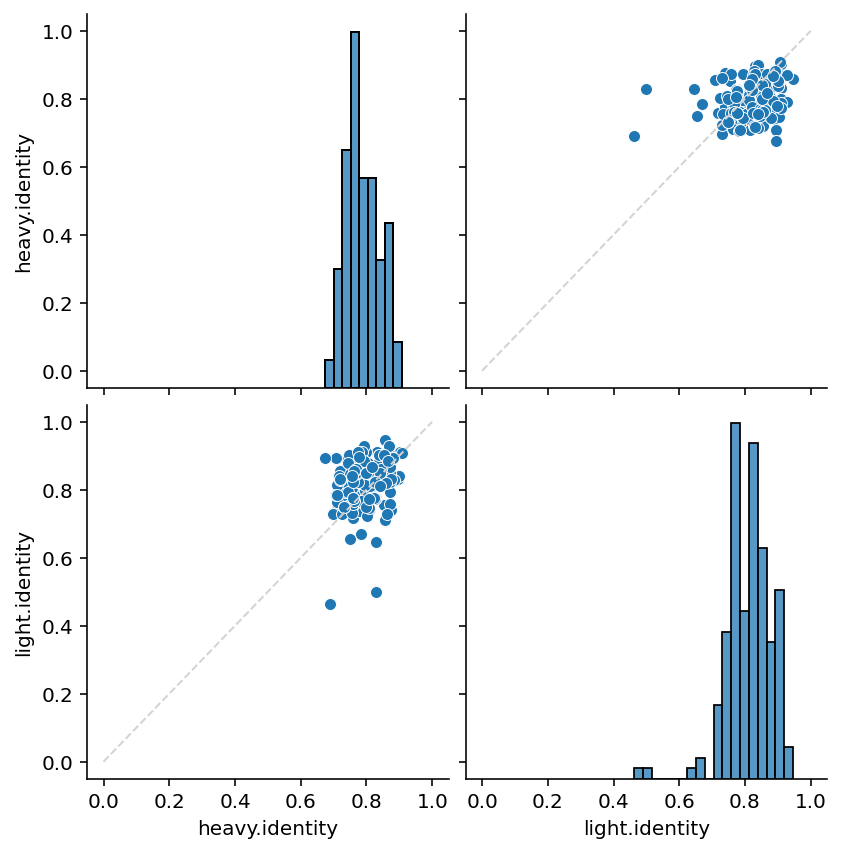

In [40]:
g = sns.pairplot(data=hits, vars=['heavy.identity', 'light.identity'], height=3);

for i in range(0, 2):
    for j in range(0, 2):
        if i != j:
            g.axes[i][j].plot([0, 1], [0, 1], ls='--', lw=1, color='lightgrey');

# Comparing to 25 known parental sequences

In [41]:
expected_heavy_chains = Chain.from_anarci_csv('../../data/tasks/humab_25_pairs/pairs/precursor_kabat_H.csv', scheme='kabat', as_series=True)
expected_heavy_chains.head()

AntiCD28       ((H1, E), (H2, V), (H3, K), (H4, L), (H5, Q), ...
Campath        ((H1, E), (H2, V), (H3, K), (H4, L), (H5, L), ...
Bevacizumab    ((H1, E), (H2, I), (H3, Q), (H4, L), (H5, V), ...
Herceptin      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Omalizumab     ((H1, D), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
dtype: object

In [42]:
expected_light_chains = Chain.from_anarci_csv('../../data/tasks/humab_25_pairs/pairs/precursor_kabat_KL.csv', scheme='kabat', as_series=True)
expected_light_chains.head()

AntiCD28       ((L1, D), (L2, I), (L3, E), (L4, T), (L5, L), ...
Campath        ((L1, D), (L2, I), (L3, K), (L4, M), (L5, T), ...
Bevacizumab    ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Herceptin      ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
Omalizumab     ((L1, D), (L2, I), (L3, Q), (L4, L), (L5, T), ...
dtype: object

In [43]:
known_index = expected_heavy_chains.index[expected_heavy_chains.index.isin(hits.index)]
len(known_index), known_index

(22,
 Index(['Bevacizumab', 'Omalizumab', 'Eculizumab', 'Tocilizumab',
        'Pembrolizumab', 'Pertuzumab', 'Ixekizumab', 'Palivizumab',
        'Certolizumab', 'Idarucizumab', 'Reslizumab', 'Solanezumab',
        'Lorvotuzumab', 'Pinatuzumab', 'Etaracizumab', 'Talacotuzumab',
        'Rovalpituzumab', 'Clazakizumab', 'Ligelizumab', 'Crizanlizumab',
        'Mogamulizumab', 'Refanezumab'],
       dtype='object'))

In [44]:
def compare_expected_frameworks(query, expected, found, chain_label):
    expected_mutations = {pos: bb for pos, (aa, bb) in query.align(expected) if not pos.is_in_cdr() and aa != bb}
    found_mutations = {pos: bb for pos, (aa, bb) in query.align(found) if not pos.is_in_cdr() and aa != bb}
    
    mutated_positions = sorted(set(expected_mutations) | set(found_mutations))
    
    is_recovered = [expected_mutations.get(pos) == found_mutations.get(pos)
              for pos in mutated_positions]
    
    num_recovered = sum(is_recovered)
    accuracy = num_recovered / len(mutated_positions)
        
    print(f'{expected.name} {chain_label}: {num_recovered}/{len(mutated_positions)} recovered ({accuracy:.0%} accuracy)')
    print(expected.align(query, found))
        
    return {
        'antibody': expected.name,
        'framework_accuracy': accuracy,
        'chain_label': chain_label
    }

In [45]:
print('Expected')
print('↑↑↑↑↑')
print('Query')
print('↓↓↓↓↓')
print('OAS Hit')
print('')

accuracy = []

for query, expected, found in zip(query_heavy_chains.loc[known_index], expected_heavy_chains.loc[known_index], hit_heavy_chains.loc[known_index]):
    accuracy.append(compare_expected_frameworks(query, expected, found, chain_label='Heavy'))

for query, expected, found in zip(query_light_chains.loc[known_index], expected_light_chains.loc[known_index], hit_light_chains.loc[known_index]):
    accuracy.append(compare_expected_frameworks(query, expected, found, chain_label='Light'))

accuracy = pd.DataFrame(accuracy)

Expected
↑↑↑↑↑
Query
↓↓↓↓↓
OAS Hit

Bevacizumab Heavy: 22/31 recovered (71% accuracy)
EIQLVQSGPELKQPGETVRISCKASGYTFTNYGMNWVKQAPGKGLKWMGWINTYTGEPTYAADFKRRFTFSLETSASTAYLQISNLKNDDTATYFCAKYPHYYGSSHWYFDVWGAGTTVTVSS
|+|||+||..|.|||.++|+||.||||||||||||||+|||||||+|+||||||||||||||||||||||||+||.||||||+++|+.+|||.|+|||||||||||||||||||.||.|||||
EVQLVESGGGLVQPGGSLRLSCAASGYTFTNYGMNWVRQAPGKGLEWVGWINTYTGEPTYAADFKRRFTFSLDTSKSTAYLQMNSLRAEDTAVYYCAKYPHYYGSSHWYFDVWGQGTLVTVSS
++|||+||..|.+||.++++||.||||||||||||||||||||||+|+|||||||||||||.|||.||.|||+||.||||||+|+|+.||.|.|+||+..+|||||||||||||.||.|||||
QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINTYTGEPTYADDFKGRFAFSLETSASTAYLQINNLKNEDMATYFCAREAYYYGSSHWYFDVWGAGTTVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^^^^^^°          
Omalizumab Heavy: 1/38 recovered (3% accuracy)
DVQLQESGPGLVKPSQSLSLACSVTGYSITSGYSWNWIRQFPGNKLEWMGSIT-YDGSSNYNPSLKNRISVTRDTSQNQFFLKLNSATAEDTATYYCARGSHYFGHWHF--AVWGAGTTVTVS

In [46]:
heavy_accuracy = accuracy[accuracy['chain_label'] == 'Heavy'].sort_values(by='framework_accuracy')
heavy_accuracy['index'] = heavy_accuracy['antibody'].apply(lambda a: f'{a} (nearest: {heavy_species.loc[a]})')
heavy_accuracy['hit_identity'] = heavy_hits['identity'].loc[heavy_accuracy['antibody']].values
heavy_accuracy.head()

,antibody,framework_accuracy,chain_label,index,hit_identity
13,Pinatuzumab,0.000000,Heavy,Pinatuzumab (nearest: Camel),0.758333
9,Idarucizumab,0.000000,Heavy,Idarucizumab (nearest: rhesus),0.786885
5,Pertuzumab,0.025000,Heavy,Pertuzumab (nearest: rat),0.756303
1,Omalizumab,0.026316,Heavy,Omalizumab (nearest: rat),0.760331
17,Clazakizumab,0.031250,Heavy,Clazakizumab (nearest: Camel),0.758333


In [47]:
light_accuracy = accuracy[accuracy['chain_label'] == 'Light'].sort_values(by='framework_accuracy')
light_accuracy['index'] = light_accuracy['antibody'].apply(lambda a: f'{a} (nearest: {light_species.loc[a]})')
light_accuracy['hit_identity'] = light_hits['identity'].loc[light_accuracy['antibody']].values
light_accuracy.head()

,antibody,framework_accuracy,chain_label,index,hit_identity
39,Clazakizumab,0.035714,Light,Clazakizumab (nearest: mouse),0.718182
32,Reslizumab,0.074074,Light,Reslizumab (nearest: mouse),0.766355
28,Ixekizumab,0.333333,Light,Ixekizumab (nearest: mouse),0.892857
30,Certolizumab,0.545455,Light,Certolizumab (nearest: mouse),0.803738
29,Palivizumab,0.555556,Light,Palivizumab (nearest: mouse),0.745283


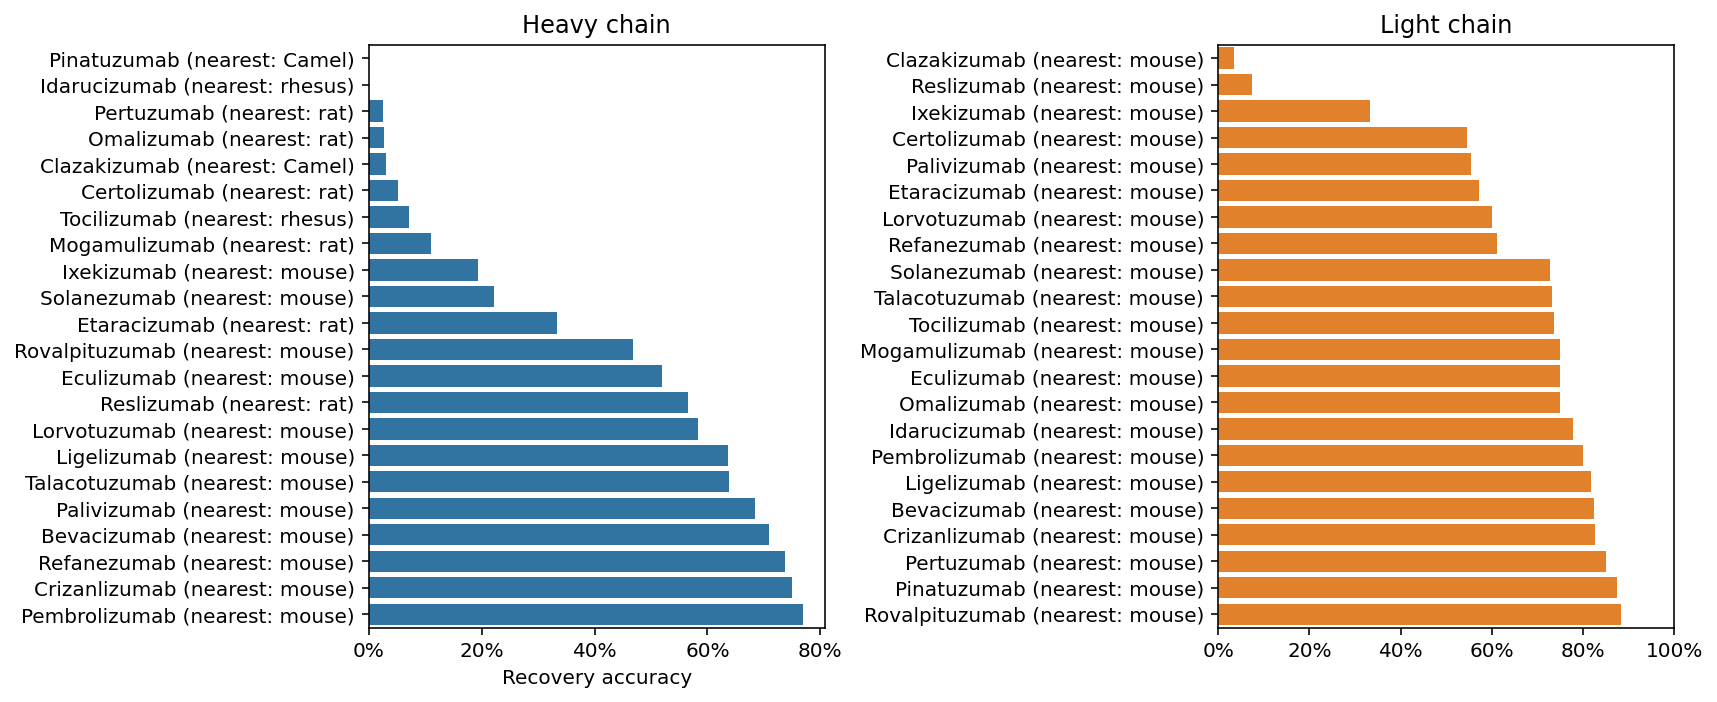

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5));

ax = sns.barplot(data=heavy_accuracy, x='framework_accuracy', y='index', color='tab:blue', ax=axes[0]);
ax.set_xlabel('Recovery accuracy')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_title('Heavy chain')
ax.set_ylabel('')

ax = sns.barplot(data=light_accuracy, x='framework_accuracy', y='index', color='tab:orange', ax=axes[1]);

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_xlim(0, 1)
ax.set_xlabel('')
ax.set_title('Light chain')
ax.set_ylabel('')

fig.tight_layout();

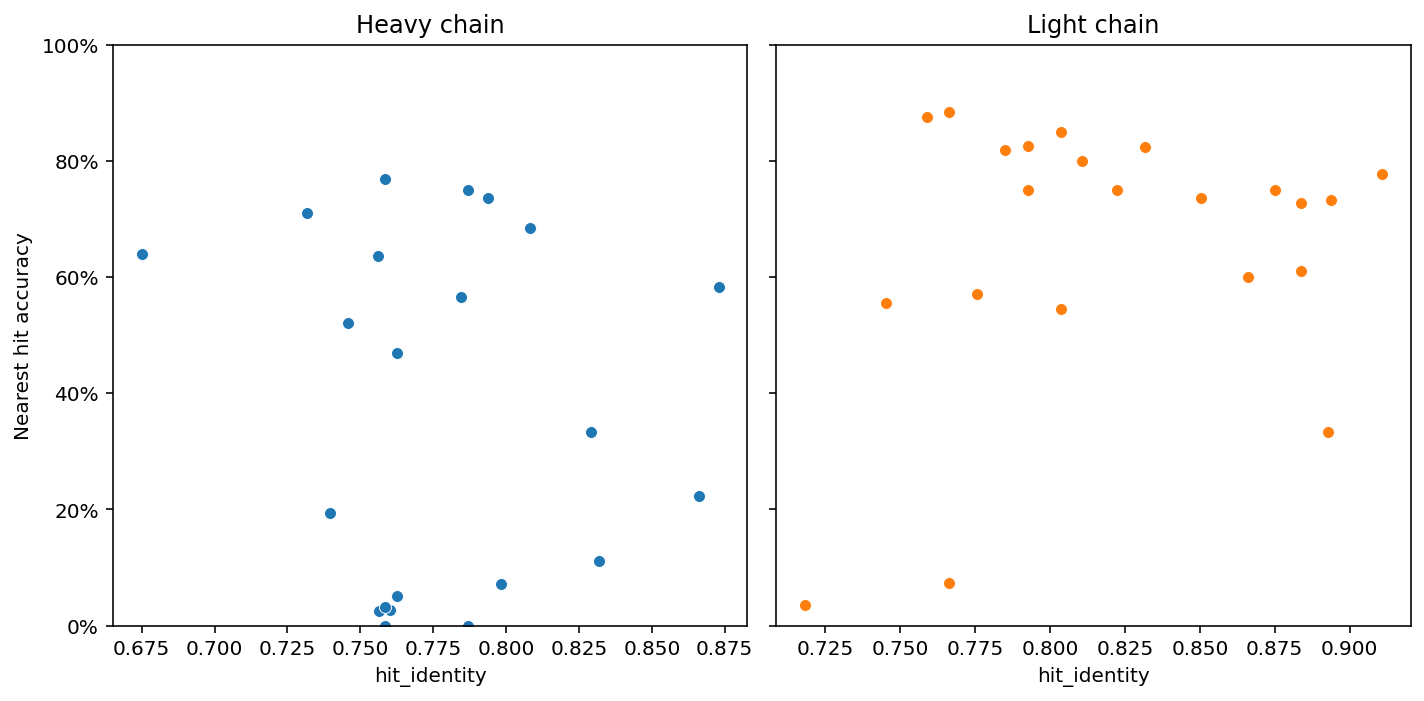

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True);

ax = sns.scatterplot(data=heavy_accuracy, y='framework_accuracy', x='hit_identity', color='tab:blue', ax=axes[0]);
ax.set_ylabel('Nearest hit accuracy')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_title('Heavy chain')

ax = sns.scatterplot(data=light_accuracy, y='framework_accuracy', x='hit_identity', color='tab:orange', ax=axes[1]);

ax.set_ylim(0, 1)
ax.set_ylabel('')
ax.set_title('Light chain')

fig.tight_layout();

In [50]:
heavy_accuracy.mean()

framework_accuracy    0.369455
hit_identity          0.778353
dtype: float64

In [51]:
light_accuracy.mean()

framework_accuracy    0.655878
hit_identity          0.819577
dtype: float64

In [52]:
heavy_accuracy.head(10)

,antibody,framework_accuracy,chain_label,index,hit_identity
13,Pinatuzumab,0.000000,Heavy,Pinatuzumab (nearest: Camel),0.758333
9,Idarucizumab,0.000000,Heavy,Idarucizumab (nearest: rhesus),0.786885
5,Pertuzumab,0.025000,Heavy,Pertuzumab (nearest: rat),0.756303
1,Omalizumab,0.026316,Heavy,Omalizumab (nearest: rat),0.760331
17,Clazakizumab,0.031250,Heavy,Clazakizumab (nearest: Camel),0.758333
8,Certolizumab,0.051282,Heavy,Certolizumab (nearest: rat),0.762712
3,Tocilizumab,0.071429,Heavy,Tocilizumab (nearest: rhesus),0.798319
20,Mogamulizumab,0.111111,Heavy,Mogamulizumab (nearest: rat),0.831933
6,Ixekizumab,0.193548,Heavy,Ixekizumab (nearest: mouse),0.739496
11,Solanezumab,0.222222,Heavy,Solanezumab (nearest: mouse),0.866071


In [53]:
light_accuracy.head()

,antibody,framework_accuracy,chain_label,index,hit_identity
39,Clazakizumab,0.035714,Light,Clazakizumab (nearest: mouse),0.718182
32,Reslizumab,0.074074,Light,Reslizumab (nearest: mouse),0.766355
28,Ixekizumab,0.333333,Light,Ixekizumab (nearest: mouse),0.892857
30,Certolizumab,0.545455,Light,Certolizumab (nearest: mouse),0.803738
29,Palivizumab,0.555556,Light,Palivizumab (nearest: mouse),0.745283


- Clazakizumab: Rabbit
- Reslizumab: Mouse (?)